In [2]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix, block_diag, identity, hstack
import matplotlib.pyplot as plt
from pyiga import assemble, bspline, vform, geometry, vis, solvers, utils, topology, algebra
from sksparse.cholmod import cholesky
from pyiga import adaptive as adap
import itertools
import time
import statistics as st

np.set_printoptions(linewidth=100000)
np.set_printoptions(precision=5)
np.set_printoptions(formatter={'float_kind':"{:.3f}".format})

Populating the interactive namespace from numpy and matplotlib


In [6]:
A = np.array([[1,0,0.5,0,0,0,0,0],[0,1,0,1,0,0.5,0,0.5],[1,0,0.5,0,1,0,0.5,0],[0,1,0,0,0,0.5,0,0]])

In [8]:
A

array([[1.000, 0.000, 0.500, 0.000, 0.000, 0.000, 0.000, 0.000],
       [0.000, 1.000, 0.000, 1.000, 0.000, 0.500, 0.000, 0.500],
       [1.000, 0.000, 0.500, 0.000, 1.000, 0.000, 0.500, 0.000],
       [0.000, 1.000, 0.000, 0.000, 0.000, 0.500, 0.000, 0.000]])

In [18]:
x=np.array([0.7,0.1,0.1,0.1,0.1,0.1])

In [21]:
adap.doerfler_mark(x, theta=0.91, TOL=0.00001)

array([1, 2, 3, 4, 5, 0])

In [10]:
abs(0.1-0.09)/0.1

0.10000000000000009

In [33]:
kv1=bspline.KnotVector(np.array([0.0,0.0,0.0,0.5,0.5,1.0,1.0,1.0]),2)
kv2 = bspline.KnotVector(np.array([0.0,0.0,0.0,1.0,1.0,1.0]),2)
kv3=bspline.KnotVector(np.array([0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0]),4)

In [34]:
bspline.prolongation(kv2,kv1).A

array([[1.000, 0.000, 0.000],
       [0.500, 0.500, 0.000],
       [0.250, 0.500, 0.250],
       [0.000, 0.500, 0.500],
       [0.000, 0.000, 1.000]])

In [35]:
bspline.prolongation(kv3,kv1).A

array([[1.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
       [-0.375, 0.500, 0.750, 0.312, -0.188, 0.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, 0.500, 0.500, 0.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, -0.188, 0.312, 0.750, 0.500, -0.375],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 1.000]])

In [99]:
N=4
deg=3
kv1=bspline.make_knots(deg,0.0,1.0,N)
kv2=bspline.make_knots(deg,0.0,1.0,N//2)
kv2=kv2.h_refine(new_knots=np.array((deg-1)*[0.5]))

In [100]:
print(kv1.kv)
print(kv2.kv)

[0.000 0.000 0.000 0.000 0.250 0.500 0.750 1.000 1.000 1.000 1.000]
[0.000 0.000 0.000 0.000 0.500 0.500 0.500 1.000 1.000 1.000 1.000]


In [101]:
bspline.prolongation(kv1,kv2).A

array([[1.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
       [-0.722, 1.444, 0.417, -0.185, 0.046, 0.000, 0.000],
       [0.278, -0.556, 0.917, 0.481, -0.120, 0.000, 0.000],
       [0.000, 0.000, 0.167, 0.667, 0.167, 0.000, 0.000],
       [0.000, 0.000, -0.120, 0.481, 0.917, -0.556, 0.278],
       [0.000, 0.000, 0.046, -0.185, 0.417, 1.444, -0.722],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 1.000]])

In [4]:
def mp_resPois2(MP, uh, f=0., a=1., M=(0.,0.), divM = 0., neu_data={}, **kwargs):
    if isinstance(a,(int,float)):
        a={d:a for d in MP.mesh.domains}
    if isinstance(f,(int,float)):
        f={d:f for d in MP.mesh.domains}
    if isinstance(divM,(int,float)):
        divM={d:divM for d in MP.mesh.domains}
    if isinstance(M, tuple):
        M = {d:M for d in MP.mesh.domains}
        
    n = MP.mesh.numpatches
    indicator = np.zeros(MP.Z_ofs[-1])
    uh_loc = MP.Basis@uh
    uh_per_patch = dict()
    
    #residual contribution, TODO vectorize
    t=time.time()
    for p, ((kvs, geo), _) in enumerate(MP.mesh.patches):
        h = np.linalg.norm([(b-a)*kv.meshsize_max()/(kv.support()[1]-kv.support()[0]) for (a,b),kv in zip(geo.bounding_box(),kvs)])
        uh_per_patch[p] = uh_loc[np.arange(MP.N[p]) + MP.N_ofs[p]]   #cache Spline Function on patch p
        kvs0 = tuple([bspline.KnotVector(kv.mesh, 0) for kv in kvs])
        u_func = geometry.BSplineFunc(kvs, uh_per_patch[p])
        d=MP.mesh.patch_domains[p]
        
        R=h**2*assemble.assemble('(f + div(a*grad(uh)) + divM)**2 * v * dx', kvs0, geo=geo, divM=divM[d], a=a[d], f=f[d], uh=u_func,**kwargs)
        indicator[MP.Z_ofs[p]:MP.Z_ofs[p+1]] = R.ravel()
    print('residual contributions took ' + str(time.time()-t) + ' seconds.')
    
    #flux contribution
    t=time.time()
    for i,((p1,b1,_), (p2,b2,_), flip) in enumerate(MP.intfs):
        ((kvs1, geo1), _), ((kvs2, geo2), _) = MP.mesh.patches[p1], MP.mesh.patches[p2]
        bdspec1, bdspec2 = [assemble.int_to_bdspec(b1)], [assemble.int_to_bdspec(b2)]
        bkv1, bkv2 = assemble.boundary_kv(kvs1, bdspec1), assemble.boundary_kv(kvs2, bdspec2)
        geo = geo2.boundary(bdspec2)
        kvs02 = tuple([bspline.KnotVector(kv.mesh, 0) for kv in kvs2])
        kvs01 = tuple([bspline.KnotVector(kv.mesh, 0) for kv in kvs1])
        bkv02 = assemble.boundary_kv(kvs02,bdspec=bdspec2)
        bkv01 = assemble.boundary_kv(kvs01,bdspec=bdspec1)
        h = np.sum(assemble.assemble('v * ds', bkv02, geo=geo))*bkv02[0].meshsize_max()/(bkv02[0].support()[1]-bkv02[0].support()[0])
        uh1_grad = geometry.BSplineFunc(kvs1, uh_per_patch[p1]).transformed_jacobian(geo1).boundary(bdspec1, flip=flip) #physical gradient of uh on patch 1 (flipped if needed)
        uh2_grad = geometry.BSplineFunc(kvs2, uh_per_patch[p2]).transformed_jacobian(geo2).boundary(bdspec2)            #physical gradient of uh on patch 2
        d1, d2 = MP.mesh.patch_domains[p1], MP.mesh.patch_domains[p2]
        J = assemble.assemble('((inner((a1 * uh1_grad + M1) - (a2 * uh2_grad + M2), n) )**2 * v ) * ds', bkv02 ,geo=geo,a1=a[d1],a2=a[d2],uh1_grad=uh1_grad,uh2_grad=uh2_grad,M1=M[d1],M2=M[d2],**kwargs)

        indicator[MP.Z_ofs[p2]+assemble.boundary_dofs(kvs02, bdspec=bdspec2, ravel=1)] += 0.5 * h * J
        indicator[MP.Z_ofs[p1]+assemble.boundary_dofs(kvs01, bdspec=bdspec1, ravel=1)] += 0.5 * h * bspline.prolongation(bkv01[0],bkv02[0]).T@J
        
    for bd in neu_data:
        g = neu_data[bd]
        for (p,b) in MP.mesh.outer_boundaries[bd]:
            ((kvs, geo), _) = MP.mesh.patches[p]
            kvs0 = tuple([bspline.KnotVector(kv.mesh, 0) for kv in kvs0])
            bdspec = [assemble.int_to_bdspec(b)]
            bkv0 = assemble.boundary_kv(kvs0, bdspec)
            geo_b = geo.boundary(bdspec)
            d=MP.mesh.patch_domains[p]
            uh_grad = geometry.BSplineFunc(kvs, uh_per_patch[p]).transformed_jacobian(geo).boundary(bdspec)
            J = np.sum(assemble.assemble('(inner(a * uh_grad, n) - g)**2 * v * ds', bkv0 ,geo=geo_b, a=a[d], uh_grad=uh_grad, **kwargs))
            indicator[MP.Z_ofs[p1]+assemble.boundary_dofs(kvs0,bdspec=bdspec, ravel=1)] += h * J
    print('jump contributions took ' + str(time.time()-t) + ' seconds.')
    return np.sqrt(indicator)

In [5]:
kvs=5*[2*(bspline.make_knots(2,0.0,1.0,3),)]
geos=geometry.mp_disk()
M = topology.PatchMesh(list(zip(kvs,geos)))
M.set_domain_id({0:{0},1:{1},2:{2},3:{3},4:{4}})
MP = assemble.Multipatch(M, automatch=True)

setting up constraints took 0.02759718894958496 seconds.
finding active constraints took 2.3365020751953125e-05 seconds.
finding derived dofs took 0.00017118453979492188 seconds.
updating basis and constraints took 0.0034296512603759766 seconds.
Basis setup took 0.006141185760498047 seconds


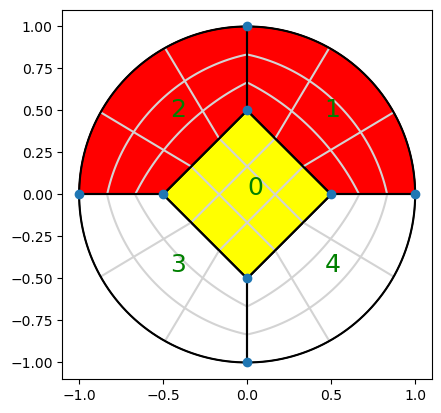

In [6]:
M.draw(knots=1, nodes=1, color={0:'yellow',1:'red',2:'red'}, patch_idx=1)

In [65]:
x = np.array([1.,1.5])
np.var(x)/np.mean(x)**2

0.04

In [7]:
def u(x,y):
    idx = (abs(x) + abs(y) > 0.5)
    vals = abs(x)+abs(y)
    vals[idx] = 0.
    return vals
u_ = MP.L2projection(u= lambda x,y: u(x,y))

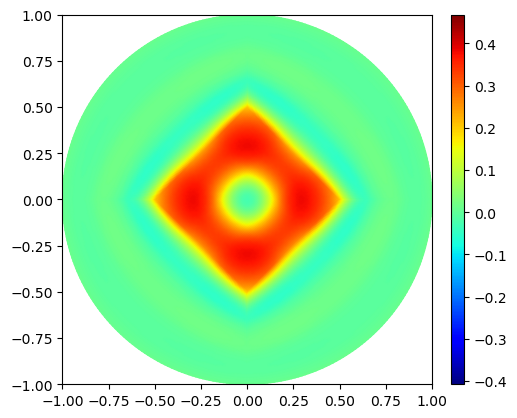

In [8]:
MP.plot(u_)

In [9]:
errors = mp_resPois2(MP, u_, f=-4.)

residual contributions took 0.2443385124206543 seconds.
jump contributions took 0.11042523384094238 seconds.


In [10]:
errors

array([2.180, 2.128, 2.180, 2.128, 4.755, 2.128, 2.180, 2.128, 2.180, 3.198, 1.286, 0.067, 2.048, 1.082, 0.315, 3.198, 1.286, 0.067, 3.198, 1.286, 0.067, 2.048, 1.082, 0.315, 3.198, 1.286, 0.067, 3.198, 1.286, 0.067, 2.048, 1.082, 0.315, 3.198, 1.286, 0.067, 3.198, 1.286, 0.067, 2.048, 1.082, 0.315, 3.198, 1.286, 0.067])

In [15]:
np.array([errors[MP.Z_ofs[p]:MP.Z_ofs[p+1]].sum() for p in range(MP.numpatches)])

array([21.985, 12.547, 12.547, 12.547, 12.547])

In [32]:
geo=geometry.quarter_annulus()

In [33]:
kvs=2*(bspline.make_knots(1,0.0,1.0,3),)
M=topology.PatchMesh([(kvs,geo)])
MP=assemble.Multipatch(M, automatch=1)

setting up constraints took 5.7220458984375e-06 seconds.
finding active constraints took 0 seconds.
finding derived dofs took 0 seconds.
updating basis and constraints took 0 seconds.
Basis setup took 0.005424022674560547 seconds


In [34]:
u_ = MP.L2projection(lambda x,y: x**2)

In [35]:
uh = bspline.BSplineFunc(kvs, u_)
grad_uh = uh.transformed_jacobian(geo=geo)

In [36]:
grad_uh.func.coeffs

array([[1.027, 1.842, 2.888, 4.168],
       [0.773, 1.386, 2.173, 3.136],
       [0.208, 0.374, 0.586, 0.846],
       [-0.046, -0.082, -0.129, -0.186]])

In [39]:
vis.plot_quiver(grad_uh, geo=geo, physical=True);
axis('scaled');

AttributeError: 'PhysicalGradientFunc' object has no attribute 'eval'

In [73]:
grd

[array([0.000, 0.111, 0.222, 0.333, 0.444, 0.556, 0.667, 0.778, 0.889, 1.000]),
 array([0.000, 0.111, 0.222, 0.333, 0.444, 0.556, 0.667, 0.778, 0.889, 1.000])]

In [76]:
C = utils.grid_eval(grad_uh, grd)
print(C)

[[[1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]]

 [[1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]]

 [[1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]]

 [[1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]]

 [[1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]]

 [[1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]
  [1.000 1.000]]

 [[1.000 1.000]
  [1.000 1.0

In [78]:
C[:,:,1]

array([[1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000],
       [1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000],
       [1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000],
       [1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000],
       [1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000],
       [1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000],
       [1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000],
       [1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000],
       [1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000],
       [1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000]])

In [84]:
grd

[array([0.000, 0.111, 0.222, 0.333, 0.444, 0.556, 0.667, 0.778, 0.889, 1.000]),
 array([0.000, 0.111, 0.222, 0.333, 0.444, 0.556, 0.667, 0.778, 0.889, 1.000])]

In [100]:
X,Y = grd[0],grd[1]

In [102]:
np.meshgrid(X,Y)

[array([[0.000, 0.111, 0.222, 0.333, 0.444, 0.556, 0.667, 0.778, 0.889, 1.000],
        [0.000, 0.111, 0.222, 0.333, 0.444, 0.556, 0.667, 0.778, 0.889, 1.000],
        [0.000, 0.111, 0.222, 0.333, 0.444, 0.556, 0.667, 0.778, 0.889, 1.000],
        [0.000, 0.111, 0.222, 0.333, 0.444, 0.556, 0.667, 0.778, 0.889, 1.000],
        [0.000, 0.111, 0.222, 0.333, 0.444, 0.556, 0.667, 0.778, 0.889, 1.000],
        [0.000, 0.111, 0.222, 0.333, 0.444, 0.556, 0.667, 0.778, 0.889, 1.000],
        [0.000, 0.111, 0.222, 0.333, 0.444, 0.556, 0.667, 0.778, 0.889, 1.000],
        [0.000, 0.111, 0.222, 0.333, 0.444, 0.556, 0.667, 0.778, 0.889, 1.000],
        [0.000, 0.111, 0.222, 0.333, 0.444, 0.556, 0.667, 0.778, 0.889, 1.000],
        [0.000, 0.111, 0.222, 0.333, 0.444, 0.556, 0.667, 0.778, 0.889, 1.000]]),
 array([[0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
        [0.111, 0.111, 0.111, 0.111, 0.111, 0.111, 0.111, 0.111, 0.111, 0.111],
        [0.222, 0.222, 0.222, 0.222, 0

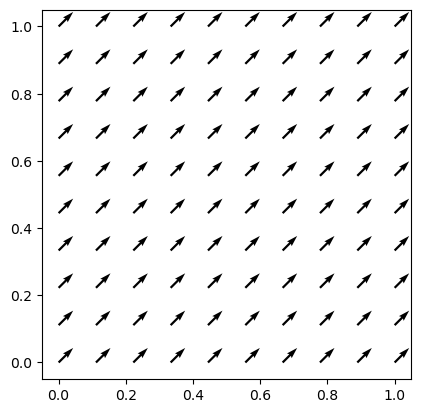

In [110]:
plt.quiver(X,Y, C[:,:,0],C[:,:,1])
axis('scaled');

In [124]:
kvy = [8,4,8,5,2,4]
kvx = [2,4,3,6,5,8]

kvs=[(bspline.make_knots(1,0.0,1.0,xN),bspline.make_knots(1,0.0,1.0,yN)) for xN,yN in zip(kvx,kvy)]
geos=[geometry.unit_square(support=((0.,1.),(0.0,0.5))).scale((2,1)),
      geometry.unit_square(support=((0.,1.),(0.5,1.))).scale((2,1)),
      geometry.Quad(np.array([[0.,2.,1.,2.],
                              [1.,1.,2.,2.]])),
      geometry.Quad(np.array([[2.,3.,2.,3.5],
                              [1.,1.,2.,2.5]])),
      geometry.Quad(np.array([[2.,3.,3.,3.5],
                              [1.,0.,1.,0.5]])),
      geometry.Quad(np.array([[2.,2.5,2.,3.],
                              [0.,-0.5,1.,0.]])),]

patches = [(tuple(bspline.mapto(k[d],lambda x: g.support[d][1]*x + g.support[d][0]*(1-x)) for d in range(2)), g) for k, g in zip(kvs,geos)]
M=topology.PatchMesh(patches)
M.sanity_check()
#M.h_refine(patches={5:-1, 2:-1});

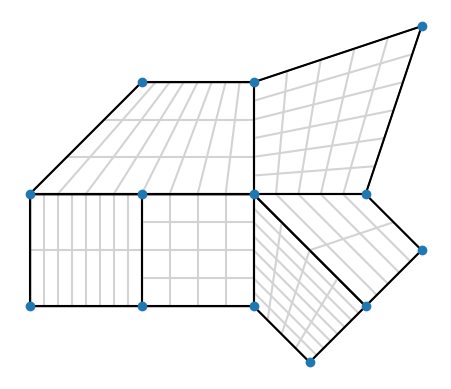

In [18]:
M.draw(knots=1, patch_idx=0, nodes=1, axis='off')
axis('scaled');

In [2]:
def drawSkeleton(MP):
    for (p,b,_),(_,_,_),_ in MP.intfs:
        ax,sd=assemble.int_to_bdspec(b)
        geo=MP.mesh.geos()[p]
        kvs=MP.mesh.kvs()[p]
        grid=np.linspace(geo.support[(ax+1)%2][0], geo.support[(ax+1)%2][1],kvs[(ax+1)%2].numdofs)
        if (p,b) == (4,1) or (p,b)==(5,3): grid=grid[1:-1]
        if ax==0:
            Z = geo.eval(grid,np.array([geo.support[0][sd]]))
        else:
            Z = geo.eval(np.array([geo.support[1][sd]]),grid)
        plt.scatter(Z[:,:,0].ravel(),Z[:,:,1].ravel(),color='red',s=15,zorder=3)
    
def drawInterior(MP,r=1):
    for p in range(MP.numpatches):
        kvs, geo = MP.mesh.kvs()[p], MP.mesh.geos()[p]
        gridx=np.linspace(geo.support[0][0],geo.support[0][1] ,kvs[0].numdofs)
        gridy=np.linspace(geo.support[1][0],geo.support[1][1],kvs[1].numdofs)
        Z = geo.eval(gridx,gridy)
        if r != 0:
            plt.scatter(Z[r:-r,r:-r,0].ravel(),Z[r:-r,r:-r,1].ravel(),color='black',s=15)
        else:
            for idx in MP.mesh.outer_boundaries:
                if (p,2) not in MP.mesh.outer_boundaries[idx]: Z = Z[1:,:,:]
                if (p,3) not in MP.mesh.outer_boundaries[idx]: Z = Z[:-1,:,:]
                if (p,0) not in MP.mesh.outer_boundaries[idx]: Z = Z[:,1:,:]
                if (p,1) not in MP.mesh.outer_boundaries[idx]: Z = Z[:,:-1,:]
            plt.scatter(Z[:,:,0].ravel(),Z[:,:,1].ravel(),color='black',s=15,zorder=2)

In [43]:
kv1=bspline.KnotVector(np.array([0.0,0.3,0.6,1.0]),0)
kv2=bspline.KnotVector(np.array([0.0,0.2,0.4,0.6,0.8,1.0]),0)

In [44]:
B=bspline.prolongation(kv1,kv2)

In [45]:
B.A.T

array([[1.000, 0.000, 0.000, 0.000, 0.000],
       [0.000, 1.000, 1.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, 1.000, 1.000]])

In [46]:
kvs=(kv1,kv2)

In [47]:
bspline.numspans(kvs)

15

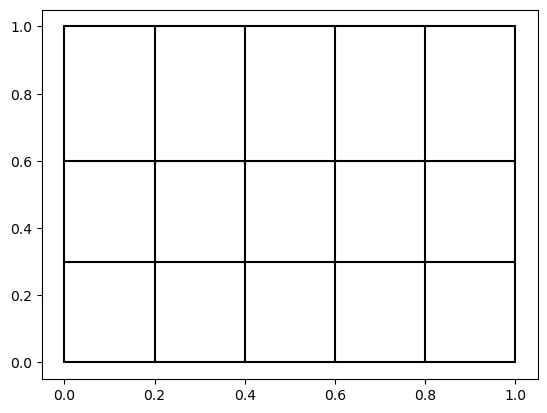

In [59]:
vis.plot_geo(geometry.unit_square(), gridx=kvs[1].mesh, gridy=kvs[0].mesh)

In [61]:
assemble.boundary_dofs(kvs, bdspec=[(0,1)], ravel=1)

array([10, 11, 12, 13, 14])

In [74]:
a={0:1}
b={0:2,3:4}

In [76]:
set(b) - set(a)

{3}

In [77]:
type('a')

str